In [1]:
# The number of entries to read in. Use it to have fast turn-around
max_events = None
# Number on CV folds
n_cv = 5

import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

import gc
import copy

import mlflow
import mlflow.sklearn

import keggler as kg

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

PATH = '/home/mlisovyi/.kaggle/competitions/santander-customer-transaction-prediction/'

print(os.listdir(PATH))

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df_trn = pd.read_csv(PATH+'train.csv')
df_tst = pd.read_csv(PATH+'test.csv')

In [4]:
df_trn = kg.reduce_mem_usage(df_trn, force_obj_in_category=False)
df_tst = kg.reduce_mem_usage(df_tst, force_obj_in_category=False)

Memory usage of dataframe is 319.76 MB
Memory usage after optimization is: 89.54 MB
Decreased by 72.0%
Memory usage of dataframe is 318.04 MB
Memory usage after optimization is: 89.16 MB
Decreased by 72.0%


In [5]:
df_trn.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,4.667969,3.875000,-5.238281,7.375000,11.578125,12.046875,11.640625,-7.015625,5.921875,-14.210938,16.031250,5.324219,12.921875,29.046875,-0.693848,5.171875,-0.747559,14.835938,11.265625,5.382812,2.017578,10.117188,16.187500,4.960938,2.076172,-0.215454,8.671875,9.531250,5.804688,22.437500,5.011719,-4.699219,21.640625,0.566406,5.199219,8.859375,43.125000,18.375000,-2.343750,23.406250,6.519531,12.195312,13.648438,13.835938,1.367188,2.941406,-4.519531,21.468750,9.320312,16.453125,8.000000,-1.707031,-21.453125,6.781250,11.093750,9.992188,14.843750,0.181152,8.960938,16.25000,2.173828,-3.414062,9.476562,13.312500,26.531250,1.440430,14.710938,6.046875,9.539062,17.156250,14.109375,24.359375,2.033203,6.761719,3.914062,-0.485107,2.523438,1.509766,2.550781,15.578125,-13.421875,7.273438,16.015625,9.726562,0.889648,0.775391,4.222656,12.000000,13.859375,-0.733887,-1.924805,15.445312,12.828125,0.358643,9.648438,6.566406,5.171875,3.134766,29.453125,31.406250,2.828125,15.656250,8.328125,-5.601562,19.062500,11.265625,8.695312,8.367188,11.562500,-16.468750,4.027344,17.921875,18.515625,10.781250,9.007812,16.703125,10.484375,1.657227,12.171875,-13.132812,17.609375,11.539062,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,10.812500,3.677734,-11.117188,1.873047,9.875000,11.781250,1.244141,-47.375000,7.371094,0.194824,34.406250,25.703125,11.835938,13.226562,-4.109375,6.687500,-8.093750,18.593750,19.328125,7.011719

# FE

In [7]:
def apply_fe(df, ss=None, mm=None):
    cols = df.columns[2:]
    if ss:
        df_ss = ss.transform(df[cols])
        for i in range(1,5):
            df['n_sigma{}'.format(i)] = (df_ss >= i).sum(axis=1)
        df['sum_sigmas'] = df_ss.sum(axis=1)
        del df_ss
        
    if mm:
        df_mm = mm.transform(df[cols])
        df['sum_mm'] = df_mm.sum(axis=1)        
        del df_mm
    
    return df

In [8]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
ss = StandardScaler().fit(df_trn.iloc[:, 2:])
mm = MinMaxScaler().fit(df_trn.iloc[:, 2:])
# scalers = [('MinMax', mm), ('StdScl', ss)]

df_trn = apply_fe(df_trn)
# df_tst = apply_fe(df_tst, ss=ss, mm=mm)

In [9]:
df_trn.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,4.667969,3.875000,-5.238281,7.375000,11.578125,12.046875,11.640625,-7.015625,5.921875,-14.210938,16.031250,5.324219,12.921875,29.046875,-0.693848,5.171875,-0.747559,14.835938,11.265625,5.382812,2.017578,10.117188,16.187500,4.960938,2.076172,-0.215454,8.671875,9.531250,5.804688,22.437500,5.011719,-4.699219,21.640625,0.566406,5.199219,8.859375,43.125000,18.375000,-2.343750,23.406250,6.519531,12.195312,13.648438,13.835938,1.367188,2.941406,-4.519531,21.468750,9.320312,16.453125,8.000000,-1.707031,-21.453125,6.781250,11.093750,9.992188,14.843750,0.181152,8.960938,16.25000,2.173828,-3.414062,9.476562,13.312500,26.531250,1.440430,14.710938,6.046875,9.539062,17.156250,14.109375,24.359375,2.033203,6.761719,3.914062,-0.485107,2.523438,1.509766,2.550781,15.578125,-13.421875,7.273438,16.015625,9.726562,0.889648,0.775391,4.222656,12.000000,13.859375,-0.733887,-1.924805,15.445312,12.828125,0.358643,9.648438,6.566406,5.171875,3.134766,29.453125,31.406250,2.828125,15.656250,8.328125,-5.601562,19.062500,11.265625,8.695312,8.367188,11.562500,-16.468750,4.027344,17.921875,18.515625,10.781250,9.007812,16.703125,10.484375,1.657227,12.171875,-13.132812,17.609375,11.539062,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,10.812500,3.677734,-11.117188,1.873047,9.875000,11.781250,1.244141,-47.375000,7.371094,0.194824,34.406250,25.703125,11.835938,13.226562,-4.109375,6.687500,-8.093750,18.593750,19.328125,7.011719

In [10]:
x = df_trn.iloc[:50000,:]

# Correlations

In [11]:
x = df_trn.iloc[:,1:]

In [12]:
x_corr = x.corr()
for v in x_corr.columns:
    x_corr.loc[v,v] = 0

In [13]:
x_corr_descr = x_corr.describe()
x_corr_descr

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,2.010000e+02,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.000216,0.000291,0.000277,0.000397,-0.000049,0.000008,0.000332,0.000458,0.000028,0.000049,-0.000394,-0.000087,0.000251,-0.000104,-0.000217,-0.000196,0.000161,0.000012,-0.000336,0.000410,0.000094,-0.000076,-0.000160,0.000307,-0.000038,0.000154,0.000141,0.000322,-0.000095,0.0000

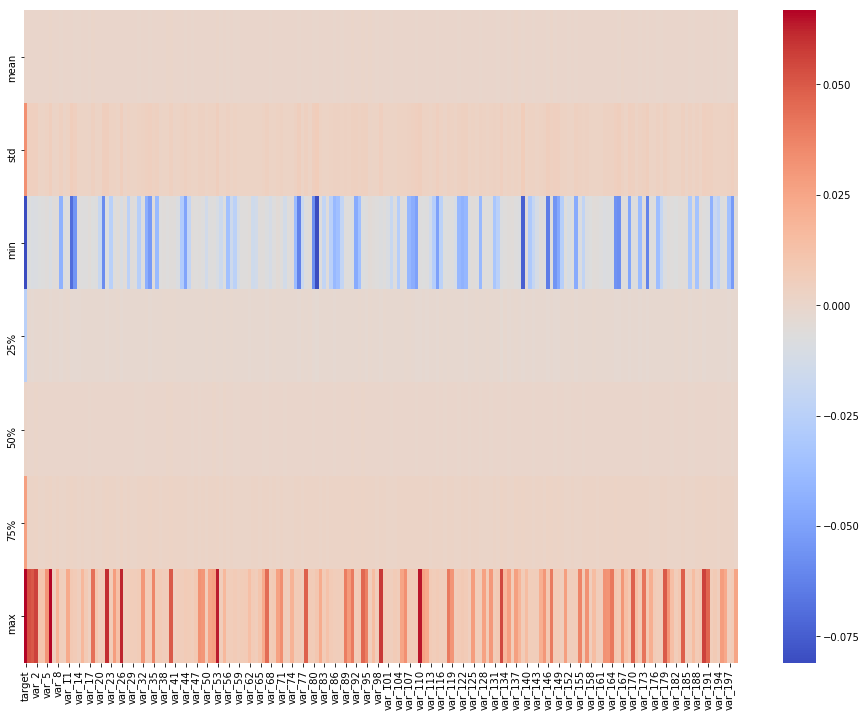

In [14]:
plt.figure(figsize=(16,12))
sns.heatmap(x_corr_descr.drop('count'), cmap='coolwarm')

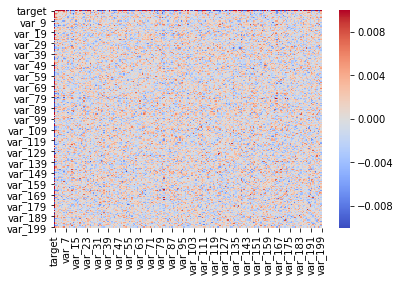

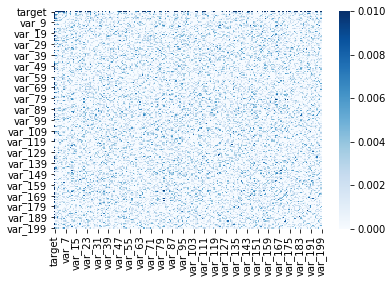

In [15]:
v=0.01
sns.heatmap(x_corr, vmax=v, vmin=-v, cmap='coolwarm')
plt.show()
sns.heatmap(x_corr, vmax=v, vmin=0, cmap='Blues')

In [16]:
x_corr_abs_topN = x_corr.iloc[1:,0].abs().sort_values(ascending=False).iloc[:20]

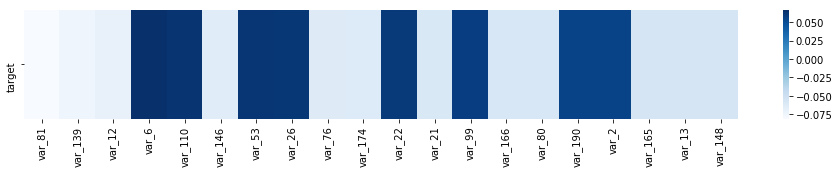

In [17]:
plt.figure(figsize=(16,2))
sns.heatmap(x_corr.loc[x_corr_abs_topN.index,['target']].T, cmap='Blues')

In [18]:
for i in range(-10,11):
    x['var_0_lag{}'.format(i)] = x['var_0'].shift(i)

In [19]:
x_corr = x.fillna(0).corr()
for v in x_corr.columns:
    x_corr.loc[v,v] = 0

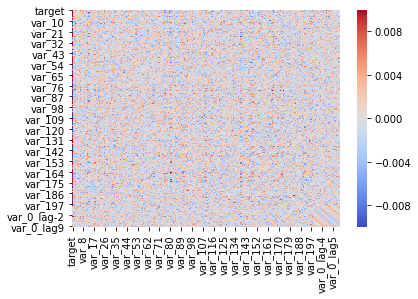

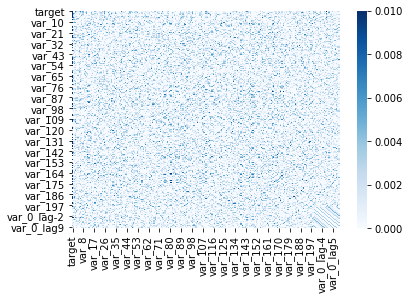

In [20]:
v=0.01
sns.heatmap(x_corr, vmax=v, vmin=-v, cmap='coolwarm')
plt.show()
sns.heatmap(x_corr, vmax=v, vmin=0, cmap='Blues')

# Describe data

In [21]:
df_trn_descr = df_trn.iloc[:,:].describe()

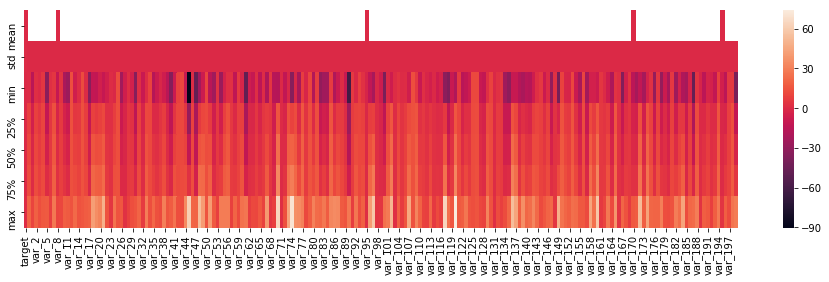

In [22]:
plt.figure(figsize=(16,4))
sns.heatmap(df_trn_descr.iloc[1:,:])

In [23]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [24]:
df_trn_mm = pd.DataFrame(MinMaxScaler().fit_transform(df_trn.iloc[:,2:]))
df_trn_ss = pd.DataFrame(StandardScaler().fit_transform(df_trn.iloc[:,2:]))

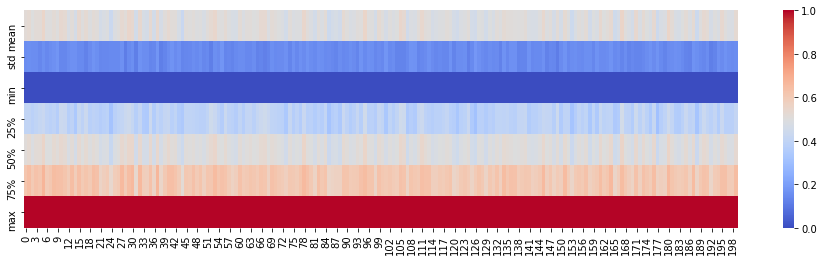

In [25]:
plt.figure(figsize=(16,4))
sns.heatmap(df_trn_mm.describe().iloc[1:,:], cmap='coolwarm')

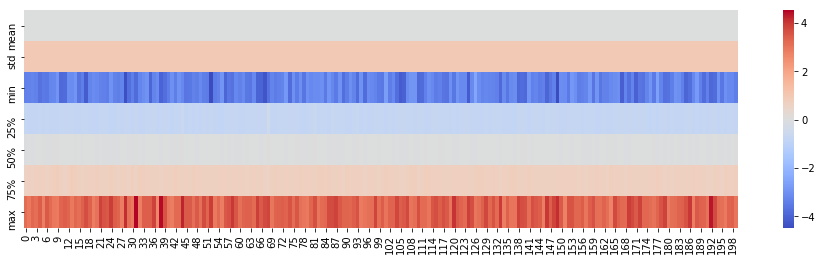

In [26]:
plt.figure(figsize=(16,4))
sns.heatmap(df_trn_ss.describe().iloc[1:,:], cmap='coolwarm')

In [27]:
df_trn_ss.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-0.578293,-1.273455,0.451005,-0.833344,0.235718,-0.536157,-0.336674,0.608282,-1.562141,-1.474535,0.460196,1.076545,-0.043925,-1.714729,0.560191,-0.006825,-1.401125,-0.229652,-1.395792,2.285975,-0.469628,-0.126779,-0.606508,-1.041653,1.005603,-0.832793,-0.184612,0.479541,-0.770126,0.360185,0.926426,1.163579,-1.299961,0.489662,-0.441157,1.300427,-0.484287,0.896917,-1.396193,0.789425,0.179632,-0.324156,0.511163,1.540362,0.456091,0.265549,-1.889394,-0.164388,0.116523,-1.445854,0.261515,1.907587,0.368059,-1.094070,-0.223987,0.367323,-1.515052,-1.118457,-0.269988,1.387539,0.954877,1.454685,0.593220,-0.281595,1.549762,2.257596,0.009496,1.424865,-0.987075,-0.345755,-0.234792,-0.387520,1.155644,-1.440008,1.672706,0.251229,-1.057479,1.136741,0.586846,-1.685823,1.056030,-0.384029,0.570624,0.230872,-0.309917,0.794682,0.477253,0.901057,-0.282134,-1.525677,-0.372925,-1.351421,-0.393152,-1.039045,1.388898,0.427444,-0.638035,-0.181110,0.589266,-1.432322,1.751000,-0.020408,0.490990,-0.691617,1.624501,2.106040,0.486258,-0.084161,-0.672766,1.355070,-0.910230,0.414924,0.374705,-1.933509,-0.566019,-0.268494,0.089776,-0.039413,-0.922436,1.013822,-0.701714,-0.923953,-0.058689,-1.024976,-0.018301,-1.537777,0.846680,-0.505277,-0.246091,-0.003626,0.686104,-0.407713,1.269335,-0.657252,1.621432,0.970663,0.624578,1.551386,0.355322,1.027276,1.001669,-1.265582,1.243694,-0.363945,0.051694,0.904233,0.484863,-1.776267,0.183825,1.215746,0.689064,0.161445,0.457389,-0.012299,0.707306,0.646542,-1.086120,-1.493514,-0.038704,0.319138,-0.808657,-1.471927,-1.231088,-1.133229,1.749376,-1.323942,-0.709152,0.442920,1.501765,-0.399867,-1.075949,-1.411323,0.121962,0.641952,-0.230953,-1.347930,-0.974910,0.701298,-0.292020,-0.311444,-1.076665,-0.779882,0.261876,1.250995,1.404454,2.086335,0.900845,-0.810710,0.557965,-0.164013,0.262977,-1.148945,0.817684,-0.410912,0.166447,-1.578560,1.022224,-0.375050,-1.026082,0.214097
1,0.269760,-0.622418,1.190578,-0.688052,0.789235,1.539858,0.244799,-0.004271,0.858880,0.419985,-0.145009,1.892768,-0.002822,-0.025040,-0.935990,-2.113115,1.757575,-1.473233,-0.948020,2.018285,-1.678484,-1.771189,1.492041,0.667226,-0.955153,0.781437,-1.301966,-0.932386,-0.620531,-1.722343,-0.202021,-1.165825,0.695186,1.064439,-0.123823,-0.599041,0.196027,-0.011180,0.039817,0.740943,-0.530447,-1.250711,-1.935893,0.682449,-1.305112,-1.619975,-1.382763,1.197236,1.730587,1.148281,-1.308417,-0.024715,-0.317030,0.887784,-1.097054,1.027740,0.762382,0.930412,-0.292489,-0.074796,-0.982337,0.404766,0.453934,-0.634622,1.165934,0.146110,-0.349303,-0.544410,0.619919,1.406063,1.348404,-0.587084,0.641207,0.066765,-0.831436,-1.618255,-0.350122,1.157207,0.079412,-0.474300,-0.436775,1.501520,0.452833,-0.704590,-0.464904,-1.170173,-2.478970,-0.044141,-0.321331,2.387657,1.294401,-0.660495,-1.109785,0.743904,0.274072,-1.912852,1.217637,0.644487,0.199096,0.773213,-0.772715,-1.011464,1.526841,0.759871,1.866348,-1.895179,-0.674345,1.880082,-1.585989,-1.233534,0.289768,0.732504,1.278129,0.090270,0.541961,0.740903,0.389090,-0.620462,-0.704910,1.070789,0.583505,-1.056105,1.369935,0.502302,-1.516447,0.328749,1.762846,0.504845,0.601380,0.258904,0.197939,-1.583792,-1.401921,0.632335,1.100059,-0.621278,-1.270186,0.061032,-0.699178,1.092326,0.055087,0.563179,-2.162310,-0.017871,-0.041467,1.597471,-0.563471,2.03340

# Cluster analysis

In [28]:
ss = StandardScaler().fit(df_trn.iloc[:,2:])
X_ss = ss.transform(df_trn.iloc[:,2:])
X_ss = pd.DataFrame(X_ss, columns=df_trn.columns[2:])

In [29]:
X_ss.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,-0.578293,-1.273455,0.451005,-0.833344,0.235718,-0.536157,-0.336674,0.608282,-1.562141,-1.474535,0.460196,1.076545,-0.043925,-1.714729,0.560191,-0.006825,-1.401125,-0.229652,-1.395792,2.285975,-0.469628,-0.126779,-0.606508,-1.041653,1.005603,-0.832793,-0.184612,0.479541,-0.770126,0.360185,0.926426,1.163579,-1.299961,0.489662,-0.441157,1.300427,-0.484287,0.896917,-1.396193,0.789425,0.179632,-0.324156,0.511163,1.540362,0.456091,0.265549,-1.889394,-0.164388,0.116523,-1.445854,0.261515,1.907587,0.368059,-1.094070,-0.223987,0.367323,-1.515052,-1.118457,-0.269988,1.387539,0.954877,1.454685,0.593220,-0.281595,1.549762,2.257596,0.009496,1.424865,-0.987075,-0.345755,-0.234792,-0.387520,1.155644,-1.440008,1.672706,0.251229,-1.057479,1.136741,0.586846,-1.685823,1.056030,-0.384029,0.570624,0.230872,-0.309917,0.794682,0.477253,0.901057,-0.282134,-1.525677,-0.372925,-1.351421,-0.393152,-1.039045,1.388898,0.427444,-0.638035,-0.181110,0.589266,-1.432322,1.751000,-0.020408,0.490990,-0.691617,1.624501,2.106040,0.486258,-0.084161,-0.672766,1.355070,-0.910230,0.414924,0.374705,-1.933509,-0.566019,-0.268494,0.089776,-0.039413,-0.922436,1.013822,-0.701714,-0.923953,-0.058689,-1.024976,-0.018301,-1.537777,0.846680,-0.505277,-0.246091,-0.003626,0.686104,-0.407713,1.269335,-0.657252,1.621432,0.970663,0.624578,1.551386,0.355322,1.027276,1.001669,-1.265582,1.243694,-0.363945,0.051694,0.904233,0.484863,-1.776267,0.183825,1.215746,0.689064,0.161445,0.457389,-0.012299,0.707306,0.646542,-1.086120,-1.493514,-0.038704,0.319138,-0.808657,-1.471927,-1.231088,-1.133229,1.749376,-1.323942,-0.709152,0.442920,1.501765,-0.399867,-1.075949,-1.411323,0.121962,0.641952,-0.230953,-1.347930,-0.974910,0.701298,-0.292020,-0.311444,-1.076665,-0.779882,0.261876,1.250995,1.404454,2.086335,0.900845,-0.810710,0.557965,-0.164013,0.262977,-1.148945,0.817684,-0.410912,0.166447,-1.578560,1.022224,-0.375050,-1.026082,0.214097
1,0.269760,-0.622418,1.190578,-0.688052,0.789235,1.539858,0.244799,-0.004271,0.858880,0.419985,-0.145009,1.892768,-0.002822,-0.025040,-0.935990,-2.113115,1.757575,-1.473233,-0.948020,2.018285,-1.678484,-1.771189,1.492041,0.667226,-0.955153,0.781437,-1.301966,-0.932386,-0.620531,-1.722343,-0.202021,-1.165825,0.695186,1.064439,-0.123823,-0.599041,0.196027,-0.011180,0.039817,0.740943,-0.530447,-1.250711,-1.935893,0.682449,-1.305112,-1.619975,-1.382763,1.197236,1.730587,1.148281,-1.308417,-0.024715,-0.317030,0.887784,-1.097054,1.027740,0.762382,0.930412,-0.292489,-0.074796,-0.982337,0.404766,0.453934,

In [30]:
import time
from sklearn.base import clone
def transform_data(tr_, X_, configs_, tr_name_):
    X_tr = {}
    for i,params in configs_.items():
        print('---------- {} -----------'.format(params))
        t_start = time.clock()
        X_tr[i] = clone(tr_).set_params(**params).fit_transform(X_)
        t_end = time.clock()
        print('{} fitted in {} sec'.format(tr_name_, t_end-t_start))
    return X_tr



colors=['r','b','y','g']
def plot_transformed_data(X_tr_, y_, configs_, tr_name_):
    for j, X_ in X_tr_.items():
        plt.figure(figsize=(6,4))
        for i in y_.unique():
            plt.scatter(X_[y_==i,0], X_[y_==i,1], c=colors[i], s=5, label=i+1)
        plt.legend()
        plt.title('{}: {}'.format(tr_name_, configs_[j]))



In [31]:
from sklearn.manifold import TSNE
tsne_configs = {#1: dict(init='random'),
                2: dict(init='pca'),
                #3: dict(init='pca', n_iter=5000),
                4: dict(init='pca', n_iter=500),
                5: dict(init='pca', learning_rate=50),
#                 6: dict(init='pca', learning_rate=500),
                7: dict(init='pca', perplexity=15),
                8: dict(init='pca', perplexity=50)
               }
# tsne_configs = {7: dict(init='pca', perplexity=15)}
X_tsne = transform_data(TSNE(n_components=2, random_state=314), 
                        X_ss.iloc[:10000,:], 
                        tsne_configs, 
                        't-SNE')

# X_tsne = transform_data(TSNE(n_components=2, random_state=314), 
#                         X_ss.iloc[:1000,:50], 
#                         tsne_configs, 
#                         't-SNE')

# X_tsne = transform_data(TSNE(n_components=2, random_state=314), 
#                         X_ss.iloc[:10000,:5], 
#                         tsne_configs, 
#                         't-SNE')

---------- {'init': 'pca', 'perplexity': 50} -----------
t-SNE fitted in 658.869784 sec
---------- {'init': 'pca'} -----------
t-SNE fitted in 609.4225150000001 sec
---------- {'init': 'pca', 'n_iter': 500} -----------
t-SNE fitted in 353.36052100000006 sec
---------- {'init': 'pca', 'learning_rate': 50} -----------
t-SNE fitted in 177.90684899999997 sec
---------- {'init': 'pca', 'perplexity': 15} -----------
t-SNE fitted in 570.0569129999999 sec


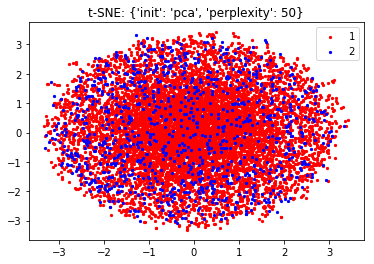

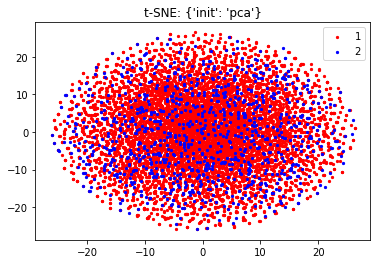

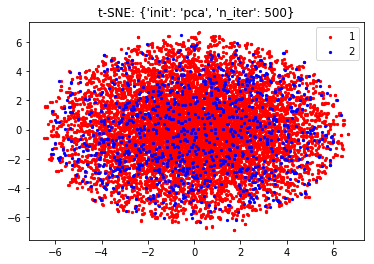

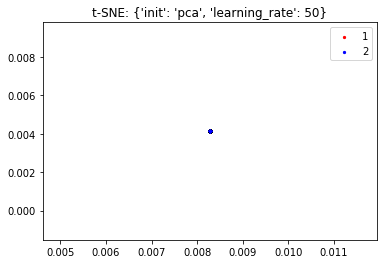

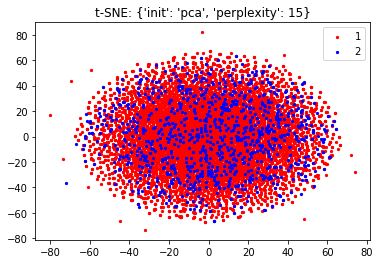

In [32]:
plot_transformed_data(X_tsne, df_trn['target'].iloc[:10000], tsne_configs, 't-SNE')

**Conclusion:** the data do not contain clusters